## Hidden loops experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy.interpolate import interp1d
from scipy.integrate import quad
from pathlib import Path
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

%cd ..

/Users/andrey/MIPT_projects/M1P_6_sem/2023-Project-119


### Defining usage and adherence

In [99]:
usage = 1
adherence = 0

In [100]:
# preparing our data
hidden_loops = Path(f"results/hidden_loops_ee_{usage}_{adherence}")
p_values = []
f_t_list = []
steps = range(10, 1251, 10)

for folder in sorted(hidden_loops.iterdir()):
    if folder.name != '.DS_Store':
        for step in steps:
            data = pd.read_csv(f"{hidden_loops}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = data['y'] - data['y_pred']
            hst = np.histogram(data_hist, density=True, bins=200)
            f_t = interp1d(hst[1][:-1], hst[0], kind='linear', 
                           fill_value=0.0, bounds_error=False)
            _, p_value = normaltest(data['y'] - data['y_pred'])
            f_t_list.append(f_t)
            p_values.append(p_value)

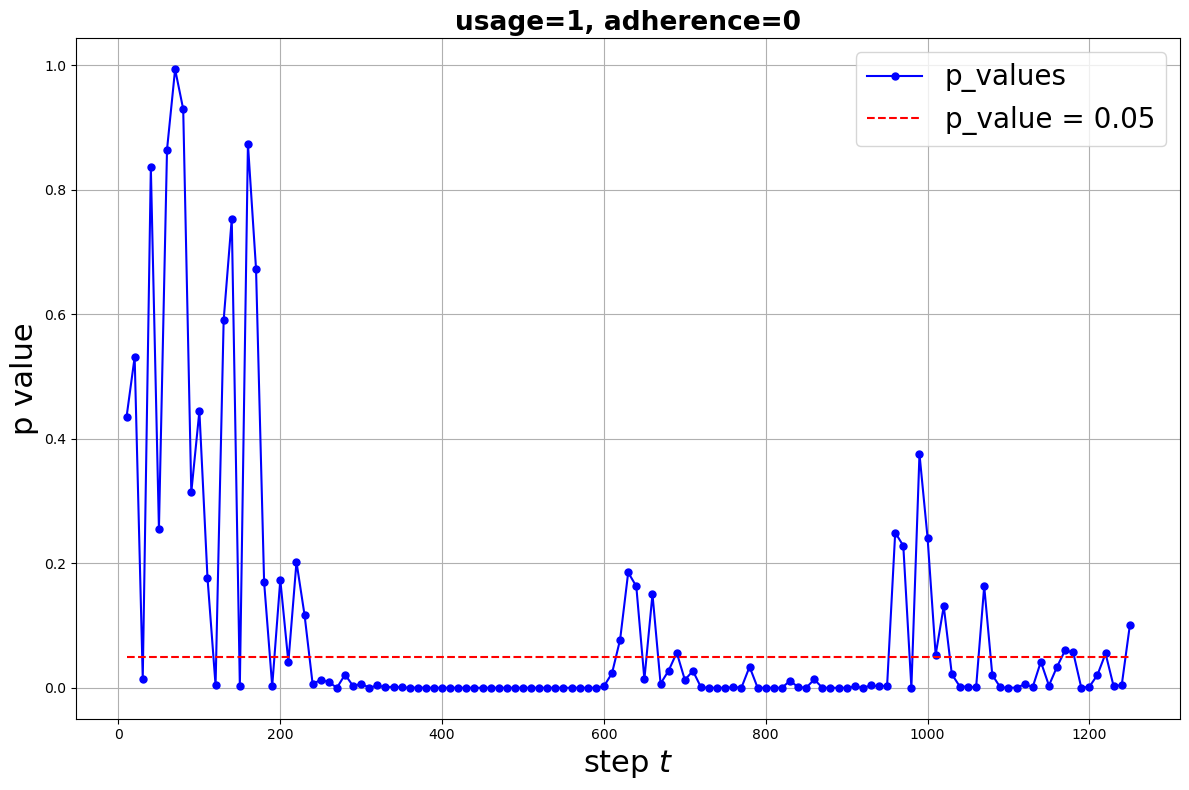

In [65]:
# plot p_values
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')

plt.xlabel(r"step $t$", fontsize=22)
plt.ylabel("p value", fontsize=22)

plt.plot(steps, p_values, label = "p_values", 
           color="blue", marker='o', markersize=5)
plt.plot(steps, [0.05]*len(steps), '--', color="red", label="p_value = 0.05")

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig(f"figures/p_loop_{usage}_{adherence}.png")
plt.show()

### Making hists

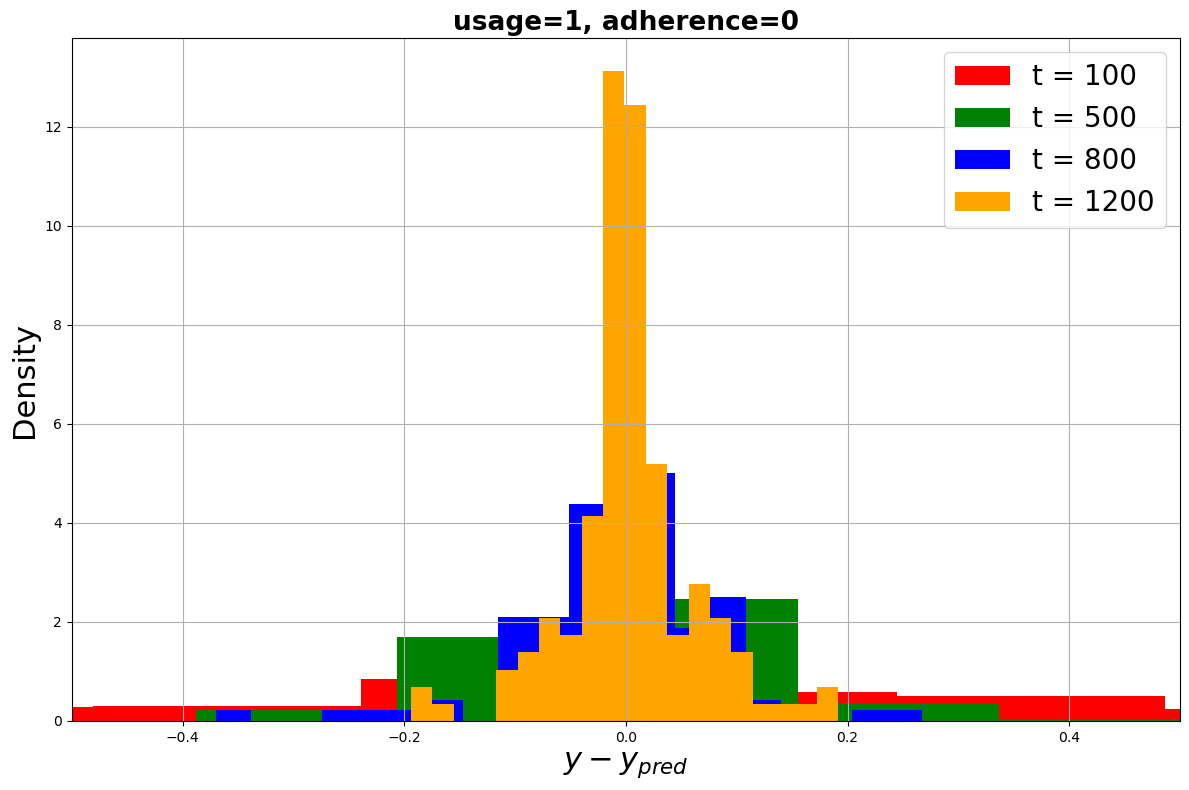

In [86]:
# plot histograms
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')
plt.xlabel(r"$y - y_{pred}$", fontsize=22)
plt.ylabel("Density", fontsize=22)
plt.xlim((-0.5, 0.5))

colors = ['red', 'green', 'blue', 'orange', 'purple',
          'cyan', 'pink', 'brown', 'black', 'olive']

steps_hist = [100, 500, 800, 1200]
for folder in sorted(hidden_loops.iterdir()):
    if folder.name != '.DS_Store':
        for step, color in zip(steps_hist, colors):
            data = pd.read_csv(f"{hidden_loops}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = np.array(data['y'] - data['y_pred'])
            hst = np.histogram(data_hist, density=True, bins=500)
            plt.hist(data_hist, bins=20, label=f"t = {step}", color=color,
                     density=True, stacked=True)
            f_t = interp1d(hst[1][:-1], hst[0], kind='cubic', 
                           fill_value=0.0, bounds_error=False)
            x_axis = np.linspace(-0.5, 0.5, 3000)
            #plt.plot(x_axis, f_t(x_axis), label=f"t = {step}", color=color)

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/hist_loop_{usage}_{adherence}.png")
plt.show()

### Limit to delta function

In [101]:
# preparing f_t(0) and int_{-kappa}^{kappa}f_t(x)dx
f_t0_list = []
integrals = []
kappa = 2.0
for f_t in f_t_list:
    f_t0_list.append(float(f_t(0.)))
    integral, _ = quad(f_t, -kappa, kappa)
    integrals.append(integral)

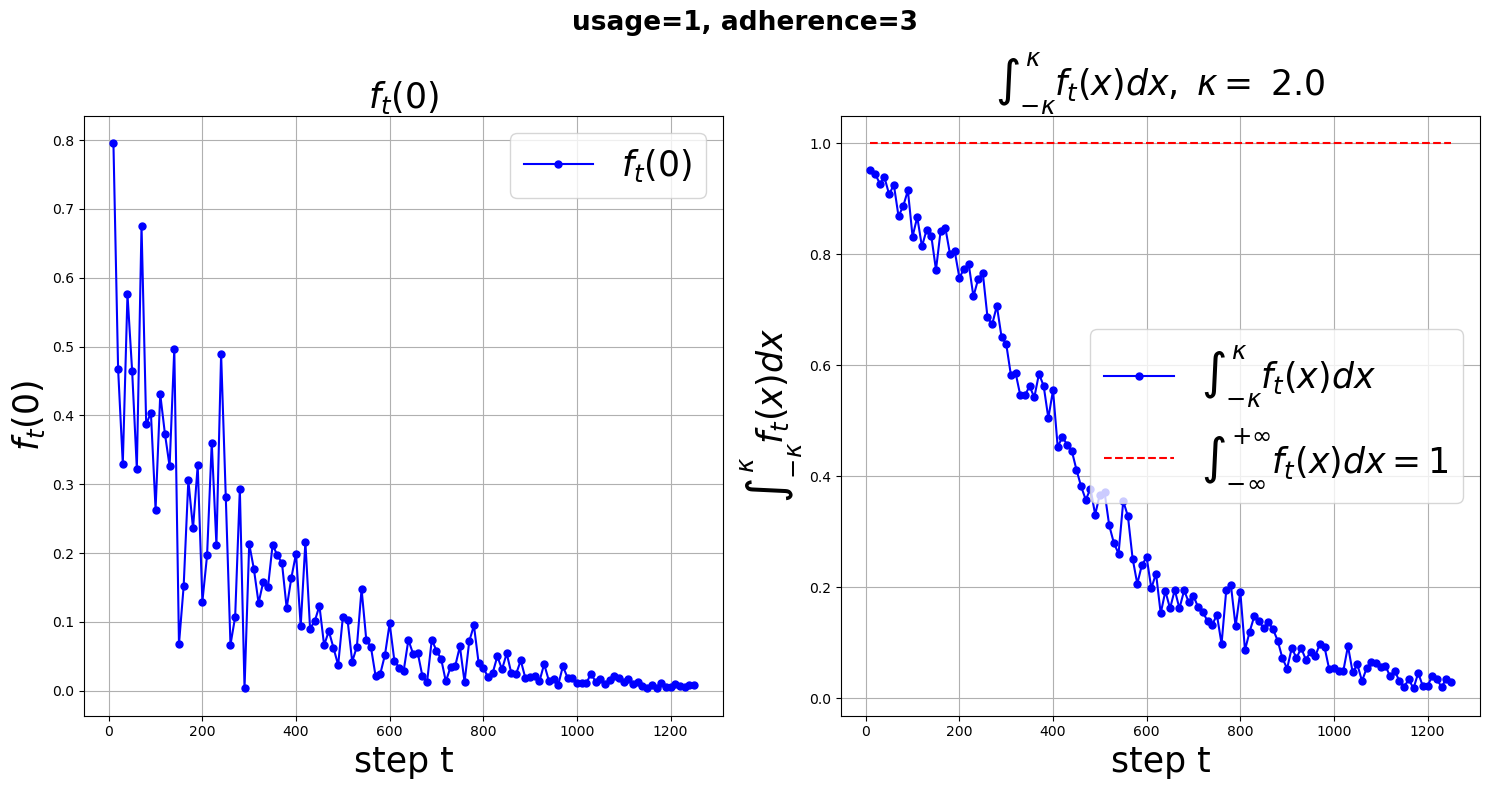

In [98]:
# plot f_t(0) and int_{-kappa}^{kappa}f_t(x)dx
plot, ax = plt.subplots(1, 2, figsize=(15, 8))
plot.suptitle(f"usage={usage}, adherence={adherence}", 
              fontsize=19, fontweight='bold')

ax[0].set_title(r"$f_t(0)$", fontsize=25, fontweight='bold')
ax[0].set_xlabel("step t", fontsize=25)
ax[0].set_ylabel(r"$f_t(0)$", fontsize=25)
ax[0].plot(steps, f_t0_list, label = r"$f_t(0)$", 
           color="blue", marker='o', markersize=5)
ax[0].legend(fontsize=25)
ax[0].grid()

ax[1].set_title(r"$\int_{-\kappa}^{\kappa}f_t(x)dx,~ \kappa = $ %.1f" % kappa, 
                fontsize=25)
ax[1].set_xlabel("step t", fontsize=25)
ax[1].set_ylabel(r"$\int_{-\kappa}^{\kappa}f_t(x)dx$", fontsize=25)
ax[1].plot(steps, integrals, label = r"$\int_{-\kappa}^{\kappa}f_t(x)dx$", 
           color="blue", marker='o', markersize=5)
ax[1].plot(steps, [1]*len(steps), '--', color="red", 
           label=r"$\int_{-\infty}^{+\infty}f_t(x)dx = 1$")
ax[1].legend(fontsize=25)
ax[1].grid()

plt.tight_layout()
plt.savefig(f"figures/ft0_loop_{usage}_{adherence}.png")
plt.show()

### Semigroup chek

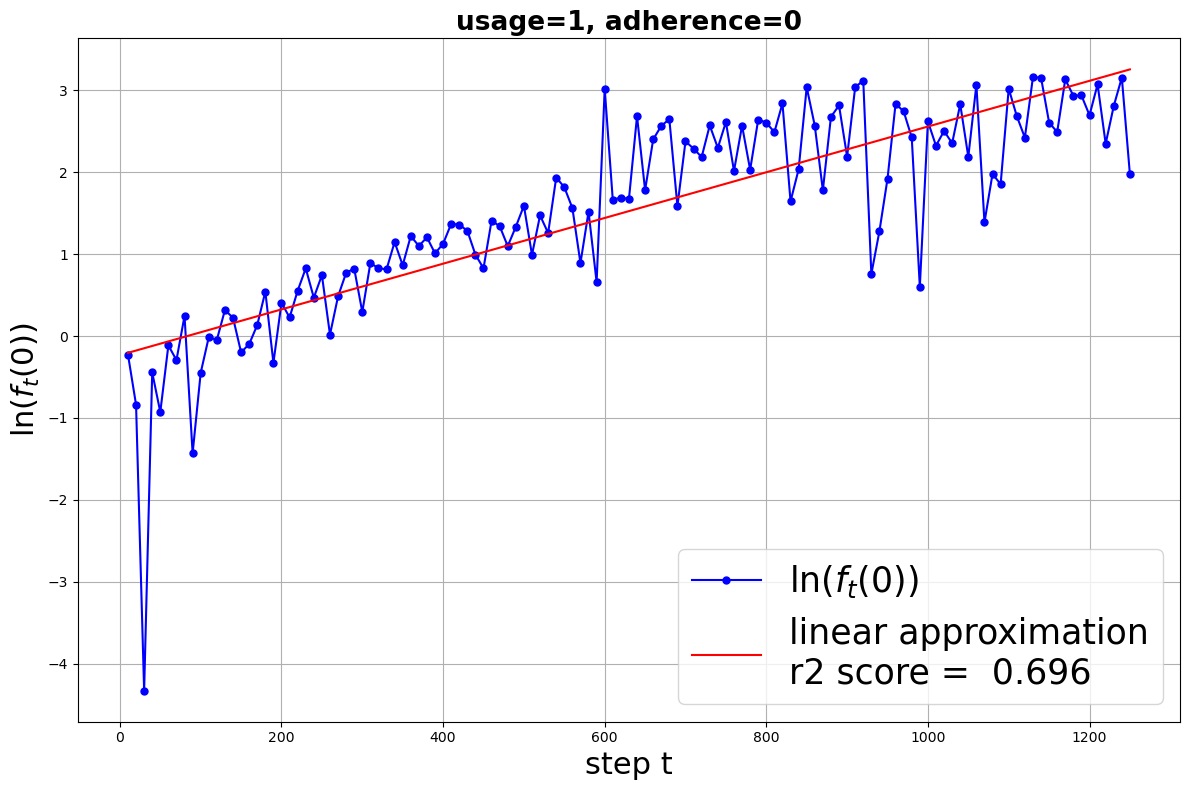

r2_score =  0.6957854458842135


In [70]:
# plot ln(f_t(0)) 
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')

plt.xlabel("step t", fontsize=22)
plt.ylabel(r"$\ln(f_t(0))$", fontsize=22)
plt.plot(steps, np.log(f_t0_list), label = r"$\ln(f_t(0))$", 
         color="blue", marker='o', markersize=5)

k, b = np.polyfit(steps, np.log(f_t0_list), deg=1)
r2score = r2_score(np.log(f_t0_list), k * steps + b)

plt.plot(steps, k*steps + b, '-', color='red', 
         label='linear approximation\nr2 score =  %.3f' % r2score)

plt.legend(fontsize=25)
plt.grid()
plt.tight_layout()
plt.savefig(f"figures/semigroup_loop_{usage}_{adherence}.png")
plt.show()
print("r2_score = ", r2score)

### Moments

In [43]:
# functions to calculate k-th moments
def k_moment(k, func):
    new_func = lambda x : (x**k) * func(x)
    integral, _ = quad(new_func, -np.inf, np.inf)
    return integral

In [54]:
# preparing ||moment_k^t||_1
l1_norms = []
N = 150
for f_t in f_t_list:
    l1_norm = 0
    for k in range(1, N+1):
        try:
            l1_norm += np.abs(k_moment(k, f_t))
        except OverflowError:
            pass
    l1_norms.append(l1_norm)

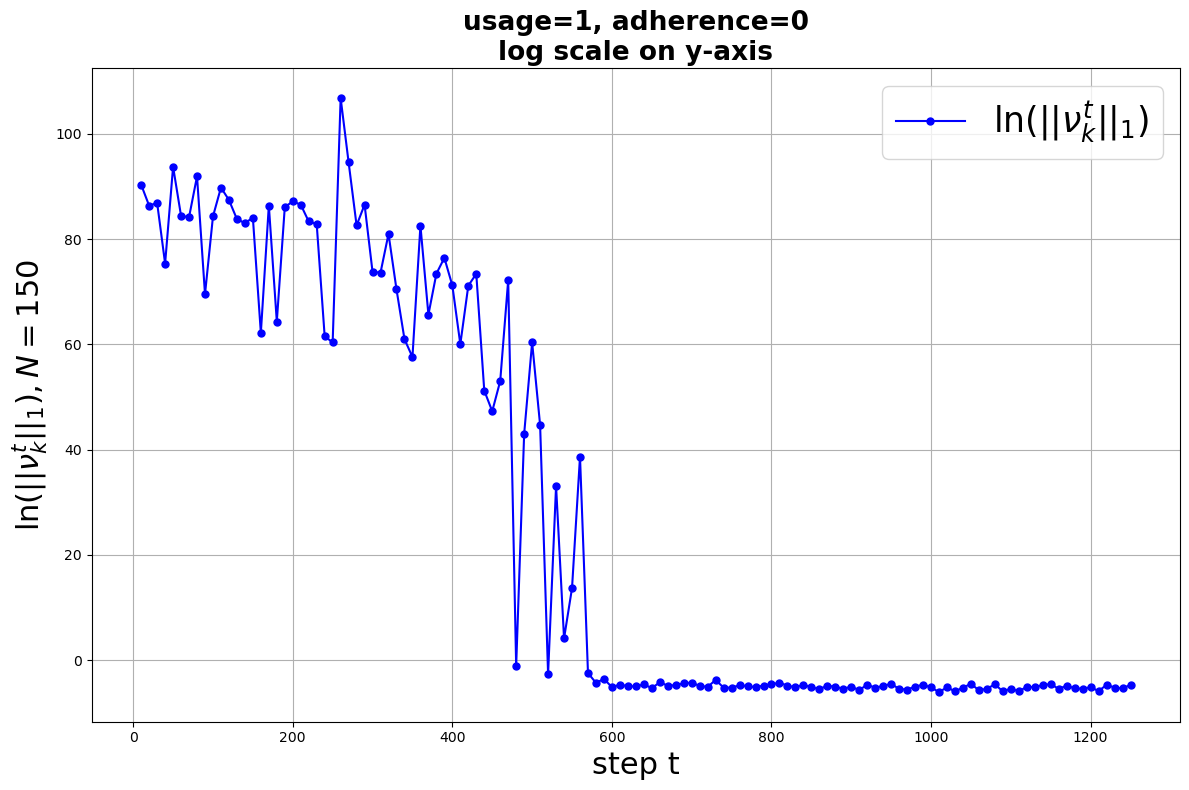

In [102]:
# plot ||moment_k^t||_1
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}\nlog scale on y-axis",
          fontsize=19, fontweight='bold')

plt.xlabel("step t", fontsize=22)
plt.ylabel(r"$\ln(||\nu_k^t||_1), N = %i$" % N, fontsize=22)

plt.plot(steps, np.log(l1_norms), label = r"$\ln(||\nu_k^t||_1)$", 
         color='blue', marker='o', markersize=5)

#plt.plot(steps, [0]*len(steps), '--', 
#         label = r"0, limit of $||\nu_k^t||_1$", color="red")
plt.legend(fontsize=25)
plt.grid()
plt.tight_layout()
plt.savefig(f"figures/moments_loop_{usage}_{adherence}.png")
plt.show()